In [1]:
WEB_SITE_NAME = 'Academicfiles.ir'
TEST_SET_SIZE = 0.99 # max = 0.999
TEST_SET_SIZE1 = 0.99 # max = 0.999

In [2]:
WEB_SITE_matrix = '../../models/' + WEB_SITE_NAME + '/view_matrix/lil_matrix.npz'
WEB_SITE_itemindexer = '../../models/' + WEB_SITE_NAME + '/view_matrix/item_indexer.indexer'
WEB_SITE_userindexer = '../../models/' + WEB_SITE_NAME + '/view_matrix/user_indexer.indexer'
SAVING1 = './alisResult/' + WEB_SITE_NAME + '/ALS/ali_item_indexer_factorized.indexer'
SAVING2 = './alisResult/' + WEB_SITE_NAME + '/ALS/ali_user_indexer_factorized.indexer'
SAVING3 = './alisResult/' + WEB_SITE_NAME + '/ALS/ali_items_vectors.npy'
SAVING4 = './alisResult/' + WEB_SITE_NAME + '/ALS/ali_users_vectors.npy'
RESULTS = '../results/ALSOpt/' + WEB_SITE_NAME + '/'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

import timeit
import time
import math
from sklearn.model_selection import train_test_split
# ./indexer
from indexer import AppendIndexer
import ALS

# Annoy
from annoy import AnnoyIndex

#SKLearn 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
from sklearn.metrics import pairwise_distances

# scipy
from scipy.spatial import distance
from scipy.sparse import lil_matrix
import scipy
import scipy.sparse
import itertools
import random

In [4]:
class ViewMatrix:
    def __init__(self, path):
        self.path = path
        self.original = True
        self.item_indexer = AppendIndexer.load(WEB_SITE_itemindexer)
        self.user_indexer = AppendIndexer.load(WEB_SITE_userindexer)
        
    def load_matrix(path):
        
        matrix = ViewMatrix(path)

        try:
            matrix.view_matrix = ViewMatrix \
                .load_sparse_lil(path)
        except:
            print('Error: loading', path)

        return matrix

    def load_sparse_lil(filename):
        loader = np.load(filename, allow_pickle=True)
        result = lil_matrix(tuple(loader["shape"]), dtype=str(loader["dtype"]))
        result.data = loader["data"]
        result.rows = loader["rows"]
        return result
    
    def make_dense(self, user_min_view, item_min_view):
        self.original = False
        while True:
            removed_rows_cnt = self.trim_users_with_few_views(user_min_view)
            removed_columns_cnt = self.trim_columns_with_few_views(item_min_view)
            if not removed_columns_cnt and not removed_rows_cnt:
                break

    def trim_users_with_few_views(self, user_min_view):
        removing_row_indices = list(np.where(self.view_matrix.getnnz(1) < user_min_view)[0])
        print('Number of users which should be deleted:', len(removing_row_indices))
        self.trim_user_indices(to_remove_indices=removing_row_indices)
        return len(removing_row_indices)

    def trim_columns_with_few_views(self, column_min_view):
        removing_column_indices = list(np.where(self.view_matrix.getnnz(0) < column_min_view)[0])
        print('Number products which should be deleted:', len(removing_column_indices))
        self.trim_column_indices(to_remove_indices=removing_column_indices)
        return len(removing_column_indices)
    
    def trim_user_indices(self, to_remove_indices):
        self.user_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_row_lil(self.view_matrix, to_remove_indices)
    
    def trim_column_indices(self, to_remove_indices):
        self.item_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_column_lil(self.view_matrix, to_remove_indices)
    
    def delete_column_lil(mat: lil_matrix, *i) -> lil_matrix:
        mat = mat.transpose()
        mat = ViewMatrix.delete_row_lil(mat, *i)
        return mat.transpose()
    
    def delete_row_lil(mat: lil_matrix, *i) -> lil_matrix:
        if not isinstance(mat, lil_matrix):
            raise ValueError("works only for LIL format -- use .tolil() first")
        mat = mat.copy()
        mat.rows = np.delete(mat.rows, i)
        mat.data = np.delete(mat.data, i)
        mat._shape = (mat.rows.shape[0], mat._shape[1])
        return mat
    def to_csr(self):
        train_data = self.view_matrix.astype(np.float64)
        train_data = train_data.tocoo()
        train_data.data = np.log10(train_data.data) + 1
        train_data = train_data.tocsr()
        return train_data

In [5]:
def ALSReady(path: str, l = 2):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = l, 
                      item_min_view = l)
    implicit_matrix = matrix.to_csr()
    print('matrix has been made dense in', time.time() - now, 'seconds.')
    return matrix, sparce_matrix, implicit_matrix

def CFTrain(matrix, implicit_matrix, _alpha = 15, _facs = 20, _itr = 15, save = False):
    
    now = time.time()
    als_model = ALS.Als(num_factors = _facs,
                        iterations = _itr,
                        num_threads = 10,
                        alpha = _alpha)

    
    als_model.fit(implicit_matrix)
    alsTime = time.time() - now
    print('ALS model is fitted in', alsTime, 'seconds.')
    if save:
        print('Saving Data ...')
        matrix.item_indexer.dump(SAVING1)
        matrix.user_indexer.dump(SAVING2)
        np.save(SAVING3, als_model.item_vectors)
        np.save(SAVING4, als_model.user_vectors)

    return als_model.item_vectors, als_model.user_vectors, alsTime

In [6]:
def get_annoy_results(pages_vector, number_of_trees = 50, number_of_neighbours = 11):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(pages_vector.shape[1], 'angular')
    
    for index, vector in enumerate(pages_vector):
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for i in pages_vector:
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

implicit matrix ro migire va ye bakhshisho baramun test o train mikone ke ye bakhshi az cell ha sefr shodan:

In [7]:
def generate_test_set_precision_recall(implicit_matrix, _test_size = 0.05, test_cells = 0.2):
    train, test = train_test_split(implicit_matrix, shuffle=False, test_size = _test_size)
    print('test_shape', test.shape, 'train_shape (which we cant process bc of RAM)', train.shape)
    rows,cols = test.nonzero()
    delete_index = [(rows[i], cols[i]) for i in random.sample(range(1, len(rows)), int(len(rows)*test_cells))]
    print("total cells", len(rows), "number of deleted cells", len(delete_index))
    
    x_train = scipy.sparse.csr_matrix(test.shape)
    for i, j in tqdm(zip(rows, cols)):
        if (i, j) in delete_index:
            continue
        x_train[i, j] = test[i, j]
    return x_train, test, delete_index

def prepare_data_for_AP(implicit_matrix, _test_size = 0.05):
    train, test = train_test_split(implicit_matrix, shuffle=False, test_size = _test_size)
    print('test_shape', test.shape, 'train_shape (which we cant process bc of RAM)', train.shape)
    rows, cols = test.nonzero()
    unique, counts = np.unique(rows, return_counts=True)
    commulative_count = [0]
    for i in counts:
        commulative_count.append(commulative_count[-1] + i)
    delete_row = []
    for i in range(1, len(commulative_count)):
        delete_row.append(np.random.randint(commulative_count[i-1], commulative_count[i]))
    delete_index = [(rows[i], cols[i]) for i in delete_row]
    # print(delete_row[:10], delete_index[:10], rows[:10], cols[:10], random.randrange(commulative_count[0], 10, 2) )
    print("total cells", len(rows), "number of deleted cells", len(delete_index))
    
    x_train = scipy.sparse.csr_matrix(test.shape)
    for i, j in zip(rows, cols):
        if (i, j) in delete_index:
            continue
        x_train[i, j] = test[i, j]
    return x_train, test, delete_index

def prepare_data_for_MAE(implicit_matrix, set_size = 0.05):
    train, test = train_test_split(implicit_matrix, shuffle=False, test_size = set_size)
    return test

In [8]:
def hit_rate_at_k(deleted, x_train, test_approx, k = 10):
    found = []
    for i in tqdm(range(len(test_approx))):
        ta = list(n_argmax(test_approx[i], 30))
        nonz = np.nonzero(x_train[i])[0]
        same_old = []
        for l in range(len(ta)):
            if ta[l] in nonz:
                same_old.append(l)

        for l in same_old[::-1]:
            ta.pop(l)
        ta = ta[:k]        
        for j in ta:
            found.append((i, j))
    same = 0
    a = np.array([hash(i) for i in found])
    b = np.array([hash(i) for i in deleted])
    same = np.sum(np.isin(b,a))
    print(same, len(deleted), same/len(deleted))
    return same/len(deleted)

def visited_at_k(x_train, test_approx, k = 10):
    same_old = []
    for i in tqdm(range(len(test_approx))):
        ta = list(n_argmax(test_approx[i], k))
        nonz = np.nonzero(x_train[i])[0]
        for l in range(len(ta)):
            if ta[l] in nonz:
                same_old.append(l)
    rows,cols = x_train.nonzero()
    return len(same_old)/len(rows)

def n_argmax(a, n):
    ranked = np.argsort(a)
    largest_indices = ranked[::-1][:n]
    return largest_indices

In [9]:
#random search
itrs1 = [15, 15, 15, 15, 15, 15]
alphas1 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
factors1 = [5, 10, 20, 40, 60, 100]

itrs2 = [15, 15, 15, 15, 15, 15]
alphas2 = [10, 10, 10, 10, 10, 10]
factors2 = [5, 10, 20, 40, 60, 100]

itrs3 = [15, 15, 15, 15, 15, 15]
alphas3 = [100, 100, 100, 100, 100, 100]
factors3 = [5, 10, 20, 40, 60, 100]

itrs4 = [15, 15, 15, 15, 15, 15]
alphas4 = [1000, 1000, 1000, 1000, 1000, 1000]
factors4 = [5, 10, 20, 40, 60, 100]

itrs = [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
alphas = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10, 10, 10, 10, 10, 10, 100, 100, 100, 100, 100, 100, 1000, 1000, 1000, 1000, 1000, 1000]
factors = [5, 10, 20, 40, 60, 100, 5, 10, 20, 40, 60, 100, 5, 10, 20, 40, 60, 100, 5, 10, 20, 40, 60, 100]

### metrics

accuracy metrics:
- recall@k, hit_rate@k
- visited_rate@k
- MAE on train set per iteration

time metrics:
- training time
- query time

In [10]:
def calc_visited_hitRate(alphas, itrs, factors, _l = 2, data_set_size = 0.072, log = False):
    visited3s = []
    hitRate3s = []
    visited6s = []
    hitRate6s = []
    AP3s = []
    AP6s = []
    trainingTime = []
    qTime = []
    matrix, sparce_matrix, implicit_matrix = ALSReady(WEB_SITE_matrix, l=_l)
    x_train_AP, test_AP, delete_index_AP = prepare_data_for_AP(implicit_matrix, _test_size = data_set_size)
    x_train, test, deleted = generate_test_set_precision_recall(implicit_matrix, _test_size = data_set_size)
    for a,i,f in zip(alphas, itrs, factors):
        if log: print('------alphas, itrs, factors------', a,i,f)
        item_vectors, user_vectors, alsTime = \
        CFTrain(None, x_train, _alpha = a, _facs = f, _itr = i)
        a1, a2, duration = get_annoy_results(item_vectors)
        qTime.append(duration)
        trainingTime.append(alsTime)
        if log: print('training and querry time:', trainingTime[-1], qTime[-1])
        test_approx = np.matmul(user_vectors, item_vectors.T)
        visited3s.append(visited_at_k(x_train.toarray(), test_approx, k = 3))
        if log: print('visited3s', visited3s[-1])
        visited6s.append(visited_at_k(x_train.toarray(), test_approx, k = 6))
        if log: print('visited6s', visited6s[-1])
        hitRate3s.append(hit_rate_at_k(deleted, x_train.toarray(), test_approx, k = 3))
        if log: print('hitRate3s', hitRate3s[-1])
        hitRate6s.append(hit_rate_at_k(deleted, x_train.toarray(), test_approx, k = 6))
        if log: print('hitRate6s', hitRate6s[-1])
        item_vectors_AP, user_vectors_AP, alsTime_AP = \
        CFTrain(None, x_train_AP, _alpha = a, _facs = f, _itr = i)
        test_approx_AP = np.matmul(user_vectors_AP, item_vectors_AP.T)
        AP3s.append(hit_rate_at_k(delete_index_AP, x_train_AP, test_approx_AP, k = 3))
        if log: print('AP3s', AP3s[-1])
        AP6s.append(hit_rate_at_k(delete_index_AP, x_train_AP, test_approx_AP, k = 6))
        if log: print('AP6s', AP6s[-1])
    return visited3s, visited6s, hitRate3s, hitRate6s, AP3s, AP6s, trainingTime, qTime

In [11]:
def calc_mse__(alphas, itrs, factors, _l = 3, data_set_size = 0.072, log = False):
    mse = []
    matrix, sparce_matrix, implicit_matrix = ALSReady(WEB_SITE_matrix, l=_l)
    train, test = train_test_split(implicit_matrix, shuffle=False, train_size = 0.06)
    for a,i,f in zip(alphas, itrs, factors):
        if log: print('------alphas, itrs, factors:', a,i,f, '------')
        item_vectors, user_vectors, alsTime = \
        CFTrain(None, train, _alpha = a, _facs = f, _itr = i)
        test_approx = np.matmul(user_vectors, item_vectors.T)
        mse.append(MSE(test_approx, train))
        print('MSE', mse[-1])
    return mse

In [12]:
def MAE(approx, train):
    absolute_error = np.absolute(train - approximated_matrix)
    return np.mean(absolute_error)
def MSE(approx, train):
    absolute_error = np.absolute(train - approx)
    absolute_error = np.square(absolute_error)
    return np.mean(absolute_error)
def MAE_calc(train, itr = 10, facs = 20):
    item_vectors, user_vectors, alsTime = \
    CFTrain(None, train, _alpha = 100, _facs = 20, _itr = itr)
    approximated_matrix = np.matmul(user_vectors, item_vectors.T)
    absolute_error = np.absolute(train - approximated_matrix)
    return np.mean(absolute_error)
def MSE_calc(train, itr = 10, facs = 20):
    item_vectors, user_vectors, alsTime = \
    CFTrain(None, train, _alpha = 100, _facs = 25, _itr = itr)
    approximated_matrix = np.matmul(user_vectors, item_vectors.T)
    return MSE(approximated_matrix, train)

In [13]:
matrix, sparce_matrix, implicit_matrix = ALSReady(WEB_SITE_matrix, l=2)
MSEs = []
train, test = train_test_split(implicit_matrix, shuffle=False, train_size = 0.1)
print(train.shape, test.shape)
for i in [i for i in range(20)]:
    MSEs.append(MSE_calc(train, itr = i))
    print(MSEs[-1])

View matrix loaded in 0.11256742477416992 seconds.
Number of users which should be deleted: 7879
Number products which should be deleted: 75
Number of users which should be deleted: 4
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 0.3143651485443115 seconds.
(849, 435) (7650, 435)
ALS model is fitted in 0.0012693405151367188 seconds.
25.446239910527495
ALS model is fitted in 0.021869421005249023 seconds.
0.021115185970075046
ALS model is fitted in 0.03753924369812012 seconds.
0.015810083807418492
ALS model is fitted in 0.04134774208068848 seconds.
0.0143450905025935
ALS model is fitted in 0.04952526092529297 seconds.
0.013459973869760628
ALS model is fitted in 0.05810999870300293 seconds.
0.013081990393437585
ALS model is fitted in 0.07551956176757812 seconds.
0.012861522345011814
ALS model is fitted in 0.08485102653503418 seconds.
0.012524510127983475
ALS model is fitted in 

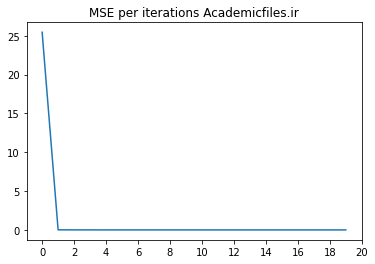

In [14]:
X = [i for i in range(20)]
plt.plot(X, MSEs)
plt.title("MSE per iterations " + WEB_SITE_NAME)
plt.xticks(np.arange(0, len(X)+1, 2))
plt.savefig(RESULTS + 'MSE_per_itrs1_' + WEB_SITE_NAME + '.png', dpi=400)

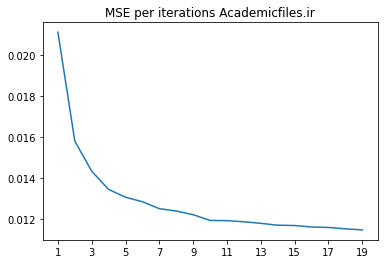

In [15]:
X = [i for i in range(1, 20)]
plt.plot(X, MSEs[1:])
plt.title("MSE per iterations " + WEB_SITE_NAME)
plt.xticks(np.arange(1, len(X)+1, 2))
plt.savefig(RESULTS + 'MSE_per_itrs2_' + WEB_SITE_NAME + '.png', dpi=400)

## Run on all

In [16]:
MSEs = []
visited3s = []
visited6s = []
hitRate3s = []
hitRate6s = []
AP3s = []
AP6s = []
trainingTime = []
qTime = []

In [17]:
visited3s1, visited6s1, hitRate3s1, hitRate6s1, AP3s1, AP6s1, trainingTime1, qTime1 = \
calc_visited_hitRate(alphas1, itrs1, factors1, _l = 2, data_set_size = TEST_SET_SIZE, log = True)
MSE1 = calc_mse__(alphas1, itrs1, factors1, _l = 2, data_set_size = TEST_SET_SIZE1, log = True)
MSEs.append(MSE1)
visited3s.append(visited3s1)
visited6s.append(visited6s1)
hitRate3s.append(hitRate3s1)
hitRate6s.append(hitRate6s1)
AP3s.append(AP3s1)
AP6s.append(AP6s1)
trainingTime.append(trainingTime1)
qTime.append(qTime1)

View matrix loaded in 0.10150504112243652 seconds.
Number of users which should be deleted: 7879
Number products which should be deleted: 75
Number of users which should be deleted: 4
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 0.32939648628234863 seconds.
test_shape (8415, 435) train_shape (which we cant process bc of RAM) (84, 435)
total cells 35156 number of deleted cells 8415


/home/yektanet/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
264it [00:00, 2629.51it/s]

test_shape (8415, 435) train_shape (which we cant process bc of RAM) (84, 435)
total cells 35156 number of deleted cells 7031


35156it [00:18, 1946.29it/s]


------alphas, itrs, factors------ 0.1 15 5


  0%|          | 0/8415 [00:00<?, ?it/s]

ALS model is fitted in 0.22468137741088867 seconds.
annoy time: 0.051375389099121094
training and querry time: 0.22468137741088867 0.051375389099121094


 28%|██▊       | 2383/8415 [00:00<00:00, 23826.78it/s]

visited3s 0.2656


 12%|█▏        | 969/8415 [00:00<00:00, 9689.34it/s]

visited6s 0.35776


 11%|█▏        | 963/8415 [00:00<00:00, 9620.15it/s]

1128 7031 0.16043237092874413
hitRate3s 0.16043237092874413


100%|██████████| 8415/8415 [00:00<00:00, 8864.00it/s]


2061 7031 0.2931304224150192
hitRate6s 0.2931304224150192


  2%|▏         | 204/8415 [00:00<00:04, 2036.74it/s]

ALS model is fitted in 0.2235255241394043 seconds.


  4%|▍         | 368/8415 [00:00<00:02, 3671.26it/s]

1086 8415 0.12905525846702318
AP3s 0.12905525846702318


100%|██████████| 8415/8415 [00:02<00:00, 3868.51it/s]


2215 8415 0.26322043969102793
AP6s 0.26322043969102793
------alphas, itrs, factors------ 0.1 15 10


  0%|          | 0/8415 [00:00<?, ?it/s]

ALS model is fitted in 0.362781286239624 seconds.
annoy time: 0.04450535774230957
training and querry time: 0.362781286239624 0.04450535774230957


 27%|██▋       | 2311/8415 [00:00<00:00, 23102.92it/s]

visited3s 0.43790222222222225


 11%|█         | 933/8415 [00:00<00:00, 9326.52it/s]

visited6s 0.5137066666666666


 11%|█▏        | 958/8415 [00:00<00:00, 9575.53it/s]

854 7031 0.1214620964300953
hitRate3s 0.1214620964300953


100%|██████████| 8415/8415 [00:00<00:00, 9468.14it/s]


1329 7031 0.1890200540463661
hitRate6s 0.1890200540463661


  2%|▏         | 209/8415 [00:00<00:03, 2084.92it/s]

ALS model is fitted in 0.3595397472381592 seconds.


  5%|▍         | 391/8415 [00:00<00:02, 3902.26it/s]

917 8415 0.10897207367795603
AP3s 0.10897207367795603


100%|██████████| 8415/8415 [00:02<00:00, 3858.02it/s]


1772 8415 0.21057635175282233
AP6s 0.21057635175282233
------alphas, itrs, factors------ 0.1 15 20


 16%|█▌        | 1365/8415 [00:00<00:00, 13644.58it/s]

ALS model is fitted in 0.5687518119812012 seconds.
annoy time: 0.04803323745727539
training and querry time: 0.5687518119812012 0.04803323745727539


 26%|██▌       | 2198/8415 [00:00<00:00, 21979.29it/s]

visited3s 0.5356088888888889


 11%|█         | 930/8415 [00:00<00:00, 9297.59it/s]

visited6s 0.6353777777777778


 11%|█         | 898/8415 [00:00<00:00, 8973.59it/s]

413 7031 0.05873986630635756
hitRate3s 0.05873986630635756


100%|██████████| 8415/8415 [00:00<00:00, 9018.25it/s]


745 7031 0.10595932299815104
hitRate6s 0.10595932299815104


  2%|▏         | 178/8415 [00:00<00:04, 1776.97it/s]

ALS model is fitted in 0.5923547744750977 seconds.


  5%|▍         | 387/8415 [00:00<00:02, 3869.27it/s]

534 8415 0.06345811051693405
AP3s 0.06345811051693405


100%|██████████| 8415/8415 [00:02<00:00, 3781.41it/s]


972 8415 0.11550802139037433
AP6s 0.11550802139037433
------alphas, itrs, factors------ 0.1 15 40


 17%|█▋        | 1463/8415 [00:00<00:00, 14624.09it/s]

ALS model is fitted in 3.8977158069610596 seconds.
annoy time: 0.04873156547546387
training and querry time: 3.8977158069610596 0.04873156547546387


 26%|██▌       | 2154/8415 [00:00<00:00, 21532.63it/s]

visited3s 0.6250666666666667


 11%|█         | 893/8415 [00:00<00:00, 8927.58it/s]

visited6s 0.7715911111111111


 11%|█         | 904/8415 [00:00<00:00, 9035.55it/s]

206 7031 0.029298819513582704
hitRate3s 0.029298819513582704


100%|██████████| 8415/8415 [00:00<00:00, 8904.87it/s]


322 7031 0.045797183899871995
hitRate6s 0.045797183899871995


  2%|▏         | 202/8415 [00:00<00:04, 2014.43it/s]

ALS model is fitted in 3.6268422603607178 seconds.


  4%|▍         | 366/8415 [00:00<00:02, 3650.11it/s]

191 8415 0.022697563874034463
AP3s 0.022697563874034463


100%|██████████| 8415/8415 [00:02<00:00, 3717.82it/s]


358 8415 0.042543077837195485
AP6s 0.042543077837195485
------alphas, itrs, factors------ 0.1 15 60


  0%|          | 0/8415 [00:00<?, ?it/s]

ALS model is fitted in 7.4930126667022705 seconds.
annoy time: 0.08044886589050293
training and querry time: 7.4930126667022705 0.08044886589050293


 23%|██▎       | 1961/8415 [00:00<00:00, 19602.26it/s]

visited3s 0.6473955555555555


  7%|▋         | 599/8415 [00:00<00:01, 5985.68it/s]

visited6s 0.81408


 10%|▉         | 802/8415 [00:00<00:00, 8010.71it/s]

145 7031 0.020622955482861614
hitRate3s 0.020622955482861614


100%|██████████| 8415/8415 [00:01<00:00, 8147.34it/s]


238 7031 0.033850092447731475
hitRate6s 0.033850092447731475


  1%|▏         | 106/8415 [00:00<00:07, 1057.78it/s]

ALS model is fitted in 7.81542444229126 seconds.


  4%|▍         | 357/8415 [00:00<00:02, 3563.45it/s]

105 8415 0.012477718360071301
AP3s 0.012477718360071301


100%|██████████| 8415/8415 [00:02<00:00, 3513.05it/s]


242 8415 0.02875816993464052
AP6s 0.02875816993464052
------alphas, itrs, factors------ 0.1 15 100


  8%|▊         | 714/8415 [00:00<00:01, 7137.30it/s]

ALS model is fitted in 14.851090431213379 seconds.
annoy time: 0.07024121284484863
training and querry time: 14.851090431213379 0.07024121284484863


 24%|██▍       | 2035/8415 [00:00<00:00, 20347.35it/s]

visited3s 0.6779022222222222


 10%|█         | 850/8415 [00:00<00:00, 8494.30it/s]

visited6s 0.8644977777777778


 10%|▉         | 808/8415 [00:00<00:00, 8077.37it/s]

104 7031 0.014791637035983502
hitRate3s 0.014791637035983502


100%|██████████| 8415/8415 [00:00<00:00, 8442.21it/s]


180 7031 0.02560091025458683
hitRate6s 0.02560091025458683


  1%|          | 101/8415 [00:00<00:08, 1009.10it/s]

ALS model is fitted in 15.98782992362976 seconds.


  4%|▍         | 317/8415 [00:00<00:02, 3168.33it/s]

46 8415 0.00546642899584076
AP3s 0.00546642899584076


100%|██████████| 8415/8415 [00:02<00:00, 3493.97it/s]


140 8415 0.016636957813428402
AP6s 0.016636957813428402
View matrix loaded in 0.10509467124938965 seconds.
Number of users which should be deleted: 7879
Number products which should be deleted: 75
Number of users which should be deleted: 4
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 0.3442525863647461 seconds.
------alphas, itrs, factors: 0.1 15 5 ------
ALS model is fitted in 0.02778792381286621 seconds.
MSE 0.007777790674847153
------alphas, itrs, factors: 0.1 15 10 ------
ALS model is fitted in 0.04601287841796875 seconds.
MSE 0.005448706644615988
------alphas, itrs, factors: 0.1 15 20 ------
ALS model is fitted in 0.08534598350524902 seconds.
MSE 0.0031268890144342046
------alphas, itrs, factors: 0.1 15 40 ------
ALS model is fitted in 0.3571178913116455 seconds.
MSE 0.001096074055719031
------alphas, itrs, factors: 0.1 15 60 ------
ALS model is fitted in 0.73869848251

In [18]:
visited3s2, visited6s2, hitRate3s2, hitRate6s2, AP3s2, AP6s2, trainingTime2, qTime2 = \
calc_visited_hitRate(alphas2, itrs2, factors2, _l = 2, data_set_size = TEST_SET_SIZE, log = True)
MSE2 = calc_mse__(alphas2, itrs2, factors2, _l = 2, data_set_size = TEST_SET_SIZE1, log = True)
MSEs.append(MSE2)
visited3s.append(visited3s2)
visited6s.append(visited6s2)
hitRate3s.append(hitRate3s2)
hitRate6s.append(hitRate6s2)
AP3s.append(AP3s2)
AP6s.append(AP6s2)
trainingTime.append(trainingTime2)
qTime.append(qTime2)

View matrix loaded in 0.15435791015625 seconds.
Number of users which should be deleted: 7879
Number products which should be deleted: 75
Number of users which should be deleted: 4
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 0.3578779697418213 seconds.
test_shape (8415, 435) train_shape (which we cant process bc of RAM) (84, 435)
total cells 35156 number of deleted cells 8415


188it [00:00, 1874.77it/s]

test_shape (8415, 435) train_shape (which we cant process bc of RAM) (84, 435)
total cells 35156 number of deleted cells 7031


35156it [00:20, 1701.63it/s]


------alphas, itrs, factors------ 10 15 5


  0%|          | 0/8415 [00:00<?, ?it/s]

ALS model is fitted in 0.26758694648742676 seconds.
annoy time: 0.05460000038146973
training and querry time: 0.26758694648742676 0.05460000038146973


 21%|██▏       | 1805/8415 [00:00<00:00, 18043.44it/s]

visited3s 0.3409066666666667


  9%|▉         | 799/8415 [00:00<00:00, 7986.88it/s]

visited6s 0.5249777777777778


 10%|▉         | 820/8415 [00:00<00:00, 8199.62it/s]

971 7031 0.13810268809557674
hitRate3s 0.13810268809557674


100%|██████████| 8415/8415 [00:01<00:00, 8242.82it/s]


1569 7031 0.22315460105248186
hitRate6s 0.22315460105248186


  2%|▏         | 152/8415 [00:00<00:05, 1516.93it/s]

ALS model is fitted in 0.25611233711242676 seconds.


  4%|▍         | 344/8415 [00:00<00:02, 3428.32it/s]

829 8415 0.09851455733808676
AP3s 0.09851455733808676


100%|██████████| 8415/8415 [00:02<00:00, 3522.78it/s]


1404 8415 0.16684491978609625
AP6s 0.16684491978609625
------alphas, itrs, factors------ 10 15 10


 16%|█▌        | 1312/8415 [00:00<00:00, 13119.26it/s]

ALS model is fitted in 0.4179956912994385 seconds.
annoy time: 0.05089592933654785
training and querry time: 0.4179956912994385 0.05089592933654785


 23%|██▎       | 1941/8415 [00:00<00:00, 19401.92it/s]

visited3s 0.48992


  9%|▉         | 758/8415 [00:00<00:01, 7579.47it/s]

visited6s 0.6533688888888889


  9%|▉         | 782/8415 [00:00<00:00, 7816.24it/s]

808 7031 0.11491964158725644
hitRate3s 0.11491964158725644


100%|██████████| 8415/8415 [00:01<00:00, 6972.97it/s]


1373 7031 0.19527805433082066
hitRate6s 0.19527805433082066


  1%|          | 62/8415 [00:00<00:13, 618.39it/s]

ALS model is fitted in 0.457460880279541 seconds.


  4%|▎         | 313/8415 [00:00<00:02, 3126.80it/s]

668 8415 0.07938205585264409
AP3s 0.07938205585264409


100%|██████████| 8415/8415 [00:02<00:00, 3519.00it/s]


1263 8415 0.1500891265597148
AP6s 0.1500891265597148
------alphas, itrs, factors------ 10 15 20


 16%|█▌        | 1338/8415 [00:00<00:00, 13375.23it/s]

ALS model is fitted in 0.6051254272460938 seconds.
annoy time: 0.06154036521911621
training and querry time: 0.6051254272460938 0.06154036521911621


 24%|██▍       | 2028/8415 [00:00<00:00, 20278.09it/s]

visited3s 0.6213333333333333


 10%|▉         | 801/8415 [00:00<00:00, 8004.11it/s]

visited6s 0.7903644444444444


  9%|▉         | 747/8415 [00:00<00:01, 7468.12it/s]

731 7031 0.10396814108946095
hitRate3s 0.10396814108946095


100%|██████████| 8415/8415 [00:01<00:00, 8066.58it/s]


1189 7031 0.16910823495946523
hitRate6s 0.16910823495946523


  1%|          | 93/8415 [00:00<00:08, 927.69it/s]

ALS model is fitted in 0.6362824440002441 seconds.


  4%|▎         | 313/8415 [00:00<00:02, 3126.96it/s]

546 8415 0.06488413547237076
AP3s 0.06488413547237076


100%|██████████| 8415/8415 [00:02<00:00, 3429.22it/s]


1144 8415 0.13594771241830064
AP6s 0.13594771241830064
------alphas, itrs, factors------ 10 15 40


 17%|█▋        | 1401/8415 [00:00<00:00, 14009.25it/s]

ALS model is fitted in 3.9856436252593994 seconds.
annoy time: 0.05905795097351074
training and querry time: 3.9856436252593994 0.05905795097351074


 23%|██▎       | 1929/8415 [00:00<00:00, 19282.34it/s]

visited3s 0.6872533333333334


 10%|▉         | 808/8415 [00:00<00:00, 8074.37it/s]

visited6s 0.8910933333333333


  9%|▉         | 781/8415 [00:00<00:00, 7803.55it/s]

484 7031 0.06883800312900014
hitRate3s 0.06883800312900014


100%|██████████| 8415/8415 [00:00<00:00, 8609.07it/s]


693 7031 0.0985635044801593
hitRate6s 0.0985635044801593


  2%|▏         | 155/8415 [00:00<00:05, 1545.44it/s]

ALS model is fitted in 4.085539102554321 seconds.


  4%|▍         | 331/8415 [00:00<00:02, 3309.61it/s]

371 8415 0.044087938205585264
AP3s 0.044087938205585264


100%|██████████| 8415/8415 [00:02<00:00, 3516.27it/s]


723 8415 0.08591800356506239
AP6s 0.08591800356506239
------alphas, itrs, factors------ 10 15 60


 10%|▉         | 825/8415 [00:00<00:00, 8246.67it/s]

ALS model is fitted in 6.319297552108765 seconds.
annoy time: 0.06398606300354004
training and querry time: 6.319297552108765 0.06398606300354004


 23%|██▎       | 1942/8415 [00:00<00:00, 19414.37it/s]

visited3s 0.7034311111111111


 10%|█         | 847/8415 [00:00<00:00, 8468.49it/s]

visited6s 0.9136


 10%|█         | 850/8415 [00:00<00:00, 8498.27it/s]

379 7031 0.05390413881382449
hitRate3s 0.05390413881382449


100%|██████████| 8415/8415 [00:00<00:00, 8686.50it/s]


530 7031 0.075380457971839
hitRate6s 0.075380457971839


  2%|▏         | 175/8415 [00:00<00:04, 1747.90it/s]

ALS model is fitted in 6.3084797859191895 seconds.


  8%|▊         | 684/8415 [00:00<00:02, 3420.56it/s]

272 8415 0.03232323232323232
AP3s 0.03232323232323232


100%|██████████| 8415/8415 [00:02<00:00, 3465.75it/s]


527 8415 0.06262626262626263
AP6s 0.06262626262626263
------alphas, itrs, factors------ 10 15 100


  0%|          | 0/8415 [00:00<?, ?it/s]

ALS model is fitted in 15.401582956314087 seconds.
annoy time: 0.07296109199523926
training and querry time: 15.401582956314087 0.07296109199523926


 23%|██▎       | 1935/8415 [00:00<00:00, 19347.90it/s]

visited3s 0.7124977777777778


  9%|▉         | 761/8415 [00:00<00:01, 7607.96it/s]

visited6s 0.9244088888888888


 10%|█         | 847/8415 [00:00<00:00, 8466.96it/s]

204 7031 0.029014364955198407
hitRate3s 0.029014364955198407


100%|██████████| 8415/8415 [00:00<00:00, 8513.63it/s]


310 7031 0.044090456549566205
hitRate6s 0.044090456549566205


  1%|          | 88/8415 [00:00<00:09, 879.79it/s]

ALS model is fitted in 15.1312255859375 seconds.


  4%|▍         | 355/8415 [00:00<00:02, 3541.37it/s]

121 8415 0.01437908496732026
AP3s 0.01437908496732026


100%|██████████| 8415/8415 [00:02<00:00, 3493.25it/s]


294 8415 0.03493761140819964
AP6s 0.03493761140819964
View matrix loaded in 0.11051821708679199 seconds.
Number of users which should be deleted: 7879
Number products which should be deleted: 75
Number of users which should be deleted: 4
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 0.3554704189300537 seconds.
------alphas, itrs, factors: 10 15 5 ------
ALS model is fitted in 0.024465322494506836 seconds.
MSE 0.016750874306804046
------alphas, itrs, factors: 10 15 10 ------
ALS model is fitted in 0.04992866516113281 seconds.
MSE 0.012445527169990839
------alphas, itrs, factors: 10 15 20 ------
ALS model is fitted in 0.08289146423339844 seconds.
MSE 0.00659681062509547
------alphas, itrs, factors: 10 15 40 ------
ALS model is fitted in 0.46262264251708984 seconds.
MSE 0.00215602661957078
------alphas, itrs, factors: 10 15 60 ------
ALS model is fitted in 0.8112809658050537 se

In [19]:
visited3s3, visited6s3, hitRate3s3, hitRate6s3, AP3s3, AP6s3, trainingTime3, qTime3 = \
calc_visited_hitRate(alphas3, itrs3, factors3, _l = 2, data_set_size = TEST_SET_SIZE, log = True)
MSE3 = calc_mse__(alphas3, itrs3, factors3, _l = 2, data_set_size = TEST_SET_SIZE1, log = True)
MSEs.append(MSE3)
visited3s.append(visited3s3)
visited6s.append(visited6s3)
hitRate3s.append(hitRate3s3)
hitRate6s.append(hitRate6s3)
AP3s.append(AP3s3)
AP6s.append(AP6s3)
trainingTime.append(trainingTime3)
qTime.append(qTime3)

View matrix loaded in 0.15833592414855957 seconds.
Number of users which should be deleted: 7879
Number products which should be deleted: 75
Number of users which should be deleted: 4
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 0.38319897651672363 seconds.
test_shape (8415, 435) train_shape (which we cant process bc of RAM) (84, 435)
total cells 35156 number of deleted cells 8415


183it [00:00, 1827.04it/s]

test_shape (8415, 435) train_shape (which we cant process bc of RAM) (84, 435)
total cells 35156 number of deleted cells 7031


35156it [00:20, 1725.77it/s]


------alphas, itrs, factors------ 100 15 5


  0%|          | 0/8415 [00:00<?, ?it/s]

ALS model is fitted in 0.2591080665588379 seconds.
annoy time: 0.054854393005371094
training and querry time: 0.2591080665588379 0.054854393005371094


 24%|██▍       | 2024/8415 [00:00<00:00, 20231.29it/s]

visited3s 0.16675555555555555


 10%|▉         | 807/8415 [00:00<00:00, 8062.13it/s]

visited6s 0.32835555555555557


  8%|▊         | 711/8415 [00:00<00:01, 7107.87it/s]

811 7031 0.11534632342483288
hitRate3s 0.11534632342483288


100%|██████████| 8415/8415 [00:01<00:00, 7972.77it/s]


1355 7031 0.19271796330536198
hitRate6s 0.19271796330536198


  2%|▏         | 149/8415 [00:00<00:05, 1486.77it/s]

ALS model is fitted in 0.2630002498626709 seconds.


  4%|▍         | 339/8415 [00:00<00:02, 3384.21it/s]

819 8415 0.09732620320855614
AP3s 0.09732620320855614


100%|██████████| 8415/8415 [00:02<00:00, 3391.53it/s]


1392 8415 0.16541889483065952
AP6s 0.16541889483065952
------alphas, itrs, factors------ 100 15 10


 15%|█▍        | 1237/8415 [00:00<00:00, 12369.42it/s]

ALS model is fitted in 0.4022698402404785 seconds.
annoy time: 0.05366253852844238
training and querry time: 0.4022698402404785 0.05366253852844238


 23%|██▎       | 1903/8415 [00:00<00:00, 19024.39it/s]

visited3s 0.2971022222222222


  9%|▉         | 777/8415 [00:00<00:00, 7762.20it/s]

visited6s 0.5173688888888889


 10%|▉         | 814/8415 [00:00<00:00, 8138.69it/s]

742 7031 0.10553264116057459
hitRate3s 0.10553264116057459


100%|██████████| 8415/8415 [00:01<00:00, 8267.73it/s]


1272 7031 0.1809130991324136
hitRate6s 0.1809130991324136


  2%|▏         | 154/8415 [00:00<00:05, 1535.49it/s]

ALS model is fitted in 0.4242374897003174 seconds.


  4%|▍         | 326/8415 [00:00<00:02, 3254.82it/s]

712 8415 0.08461081402257872
AP3s 0.08461081402257872


100%|██████████| 8415/8415 [00:02<00:00, 3546.80it/s]


1188 8415 0.1411764705882353
AP6s 0.1411764705882353
------alphas, itrs, factors------ 100 15 20


 14%|█▍        | 1161/8415 [00:00<00:00, 11604.84it/s]

ALS model is fitted in 0.6431939601898193 seconds.
annoy time: 0.04240584373474121
training and querry time: 0.6431939601898193 0.04240584373474121


 24%|██▍       | 2043/8415 [00:00<00:00, 20426.95it/s]

visited3s 0.5530666666666667


 10%|▉         | 826/8415 [00:00<00:00, 8256.62it/s]

visited6s 0.7895466666666666


 10%|▉         | 815/8415 [00:00<00:00, 8145.04it/s]

804 7031 0.11435073247048784
hitRate3s 0.11435073247048784


100%|██████████| 8415/8415 [00:00<00:00, 8437.64it/s]


1301 7031 0.18503769022898592
hitRate6s 0.18503769022898592


  1%|▏         | 121/8415 [00:00<00:06, 1207.69it/s]

ALS model is fitted in 0.6199798583984375 seconds.


  4%|▍         | 318/8415 [00:00<00:02, 3177.53it/s]

570 8415 0.0677361853832442
AP3s 0.0677361853832442


100%|██████████| 8415/8415 [00:02<00:00, 3545.03it/s]


1111 8415 0.13202614379084968
AP6s 0.13202614379084968
------alphas, itrs, factors------ 100 15 40


  0%|          | 0/8415 [00:00<?, ?it/s]

ALS model is fitted in 4.1056067943573 seconds.
annoy time: 0.06970500946044922
training and querry time: 4.1056067943573 0.06970500946044922


 23%|██▎       | 1909/8415 [00:00<00:00, 19081.74it/s]

visited3s 0.70784


  9%|▉         | 778/8415 [00:00<00:00, 7772.54it/s]

visited6s 0.92256


  9%|▉         | 781/8415 [00:00<00:00, 7803.48it/s]

764 7031 0.10866164130280188
hitRate3s 0.10866164130280188


100%|██████████| 8415/8415 [00:00<00:00, 8579.78it/s]


1105 7031 0.1571611435073247
hitRate6s 0.1571611435073247


  1%|▏         | 122/8415 [00:00<00:06, 1217.90it/s]

ALS model is fitted in 4.213979244232178 seconds.


  4%|▎         | 304/8415 [00:00<00:02, 3035.70it/s]

295 8415 0.035056446821152706
AP3s 0.035056446821152706


100%|██████████| 8415/8415 [00:02<00:00, 3559.28it/s]


802 8415 0.09530600118835413
AP6s 0.09530600118835413
------alphas, itrs, factors------ 100 15 60


  9%|▊         | 728/8415 [00:00<00:01, 7277.82it/s]

ALS model is fitted in 6.354053258895874 seconds.
annoy time: 0.06840729713439941
training and querry time: 6.354053258895874 0.06840729713439941


 24%|██▍       | 2003/8415 [00:00<00:00, 20025.53it/s]

visited3s 0.71456


  9%|▉         | 797/8415 [00:00<00:00, 7967.44it/s]

visited6s 0.92896


 10%|█         | 881/8415 [00:00<00:00, 8807.34it/s]

501 7031 0.07125586687526668
hitRate3s 0.07125586687526668


100%|██████████| 8415/8415 [00:01<00:00, 8368.62it/s]


712 7031 0.10126582278481013
hitRate6s 0.10126582278481013


  1%|▏         | 107/8415 [00:00<00:07, 1067.71it/s]

ALS model is fitted in 6.945730686187744 seconds.


  4%|▎         | 308/8415 [00:00<00:02, 3072.88it/s]

244 8415 0.02899584076054664
AP3s 0.02899584076054664


100%|██████████| 8415/8415 [00:02<00:00, 3540.01it/s]


555 8415 0.0659536541889483
AP6s 0.0659536541889483
------alphas, itrs, factors------ 100 15 100


  0%|          | 0/8415 [00:00<?, ?it/s]

ALS model is fitted in 14.990770101547241 seconds.
annoy time: 0.07425713539123535
training and querry time: 14.990770101547241 0.07425713539123535


 22%|██▏       | 1878/8415 [00:00<00:00, 18770.98it/s]

visited3s 0.7158755555555556


 10%|▉         | 802/8415 [00:00<00:00, 8011.77it/s]

visited6s 0.9294222222222223


 10%|█         | 848/8415 [00:00<00:00, 8475.89it/s]

284 7031 0.04039254729057033
hitRate3s 0.04039254729057033


100%|██████████| 8415/8415 [00:00<00:00, 8475.51it/s]


390 7031 0.05546863888493813
hitRate6s 0.05546863888493813


  1%|          | 97/8415 [00:00<00:08, 969.97it/s]

ALS model is fitted in 19.73657202720642 seconds.


  4%|▍         | 320/8415 [00:00<00:02, 3191.58it/s]

121 8415 0.01437908496732026
AP3s 0.01437908496732026


100%|██████████| 8415/8415 [00:02<00:00, 3489.18it/s]


293 8415 0.03481877599524658
AP6s 0.03481877599524658
View matrix loaded in 0.1047816276550293 seconds.
Number of users which should be deleted: 7879
Number products which should be deleted: 75
Number of users which should be deleted: 4
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 0.3361833095550537 seconds.
------alphas, itrs, factors: 100 15 5 ------
ALS model is fitted in 0.024804115295410156 seconds.
MSE 0.049314131874696784
------alphas, itrs, factors: 100 15 10 ------
ALS model is fitted in 0.05062460899353027 seconds.
MSE 0.02825987497548507
------alphas, itrs, factors: 100 15 20 ------
ALS model is fitted in 0.07485556602478027 seconds.
MSE 0.011261766800917727
------alphas, itrs, factors: 100 15 40 ------
ALS model is fitted in 0.37659645080566406 seconds.
MSE 0.002980314535263971
------alphas, itrs, factors: 100 15 60 ------
ALS model is fitted in 1.01400423049926

In [20]:
visited3s4, visited6s4, hitRate3s4, hitRate6s4, AP3s4, AP6s4, trainingTime4, qTime4 = \
calc_visited_hitRate(alphas4, itrs4, factors4, _l = 2, data_set_size = TEST_SET_SIZE, log = True)
MSE4 = calc_mse__(alphas4, itrs4, factors4, _l = 2, data_set_size = TEST_SET_SIZE1, log = True)
MSEs.append(MSE4)
visited3s.append(visited3s4)
visited6s.append(visited6s4)
hitRate3s.append(hitRate3s4)
hitRate6s.append(hitRate6s4)
AP3s.append(AP3s4)
AP6s.append(AP6s4)
trainingTime.append(trainingTime4)
qTime.append(qTime4)

View matrix loaded in 0.1600186824798584 seconds.
Number of users which should be deleted: 7879
Number products which should be deleted: 75
Number of users which should be deleted: 4
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 0.37642526626586914 seconds.
test_shape (8415, 435) train_shape (which we cant process bc of RAM) (84, 435)
total cells 35156 number of deleted cells 8415


184it [00:00, 1825.69it/s]

test_shape (8415, 435) train_shape (which we cant process bc of RAM) (84, 435)
total cells 35156 number of deleted cells 7031


35156it [00:20, 1687.63it/s]


------alphas, itrs, factors------ 1000 15 5


  0%|          | 0/8415 [00:00<?, ?it/s]

ALS model is fitted in 0.2571702003479004 seconds.
annoy time: 0.05971693992614746
training and querry time: 0.2571702003479004 0.05971693992614746


 24%|██▍       | 2014/8415 [00:00<00:00, 20137.19it/s]

visited3s 0.11537777777777777


  9%|▉         | 797/8415 [00:00<00:00, 7962.28it/s]

visited6s 0.21578666666666665


 10%|▉         | 835/8415 [00:00<00:00, 8349.23it/s]

689 7031 0.0979945953633907
hitRate3s 0.0979945953633907


100%|██████████| 8415/8415 [00:01<00:00, 8247.98it/s]


1016 7031 0.14450291565922344
hitRate6s 0.14450291565922344


  2%|▏         | 134/8415 [00:00<00:06, 1337.73it/s]

ALS model is fitted in 0.2636451721191406 seconds.


  4%|▍         | 334/8415 [00:00<00:02, 3336.37it/s]

734 8415 0.08722519310754605
AP3s 0.08722519310754605


100%|██████████| 8415/8415 [00:02<00:00, 3383.89it/s]


1124 8415 0.13357100415923945
AP6s 0.13357100415923945
------alphas, itrs, factors------ 1000 15 10


 15%|█▍        | 1243/8415 [00:00<00:00, 12427.73it/s]

ALS model is fitted in 0.3997039794921875 seconds.
annoy time: 0.05407595634460449
training and querry time: 0.3997039794921875 0.05407595634460449


 22%|██▏       | 1892/8415 [00:00<00:00, 18913.16it/s]

visited3s 0.2276622222222222


  8%|▊         | 696/8415 [00:00<00:01, 6958.07it/s]

visited6s 0.37681777777777775


  9%|▉         | 777/8415 [00:00<00:00, 7768.82it/s]

573 7031 0.0814962309771014
hitRate3s 0.0814962309771014


100%|██████████| 8415/8415 [00:01<00:00, 8414.40it/s]


959 7031 0.13639596074527094
hitRate6s 0.13639596074527094


  2%|▏         | 167/8415 [00:00<00:04, 1668.95it/s]

ALS model is fitted in 0.40586376190185547 seconds.


  4%|▍         | 338/8415 [00:00<00:02, 3376.07it/s]

545 8415 0.0647653000594177
AP3s 0.0647653000594177


100%|██████████| 8415/8415 [00:02<00:00, 3504.71it/s]


945 8415 0.11229946524064172
AP6s 0.11229946524064172
------alphas, itrs, factors------ 1000 15 20


 10%|█         | 875/8415 [00:00<00:00, 8748.92it/s]

ALS model is fitted in 0.6476507186889648 seconds.
annoy time: 0.037920236587524414
training and querry time: 0.6476507186889648 0.037920236587524414


 24%|██▍       | 2034/8415 [00:00<00:00, 20331.29it/s]

visited3s 0.47932444444444444


 10%|▉         | 821/8415 [00:00<00:00, 8206.08it/s]

visited6s 0.7141688888888889


  9%|▉         | 777/8415 [00:00<00:00, 7756.91it/s]

692 7031 0.09842127720096715
hitRate3s 0.09842127720096715


100%|██████████| 8415/8415 [00:01<00:00, 8038.64it/s]


1119 7031 0.1591523254160148
hitRate6s 0.1591523254160148


  1%|          | 93/8415 [00:00<00:08, 928.05it/s]

ALS model is fitted in 0.6265292167663574 seconds.


  8%|▊         | 691/8415 [00:00<00:02, 3470.46it/s]

418 8415 0.04967320261437908
AP3s 0.04967320261437908


100%|██████████| 8415/8415 [00:02<00:00, 3514.29it/s]


842 8415 0.10005941770647653
AP6s 0.10005941770647653
------alphas, itrs, factors------ 1000 15 40


 13%|█▎        | 1066/8415 [00:00<00:00, 10658.92it/s]

ALS model is fitted in 4.065340995788574 seconds.
annoy time: 0.06464147567749023
training and querry time: 4.065340995788574 0.06464147567749023


 24%|██▎       | 1997/8415 [00:00<00:00, 19962.78it/s]

visited3s 0.6883911111111111


 10%|▉         | 801/8415 [00:00<00:00, 8006.99it/s]

visited6s 0.9022577777777778


  9%|▉         | 796/8415 [00:00<00:00, 7948.88it/s]

712 7031 0.10126582278481013
hitRate3s 0.10126582278481013


100%|██████████| 8415/8415 [00:01<00:00, 8200.04it/s]


1129 7031 0.1605745982079363
hitRate6s 0.1605745982079363


  1%|▏         | 109/8415 [00:00<00:07, 1087.94it/s]

ALS model is fitted in 3.9942047595977783 seconds.


  8%|▊         | 689/8415 [00:00<00:02, 3443.52it/s]

308 8415 0.036601307189542485
AP3s 0.036601307189542485


100%|██████████| 8415/8415 [00:02<00:00, 3516.05it/s]


788 8415 0.0936423054070113
AP6s 0.0936423054070113
------alphas, itrs, factors------ 1000 15 60


  9%|▉         | 749/8415 [00:00<00:01, 7488.29it/s]

ALS model is fitted in 6.432789087295532 seconds.
annoy time: 0.07021307945251465
training and querry time: 6.432789087295532 0.07021307945251465


 21%|██        | 1786/8415 [00:00<00:00, 17851.42it/s]

visited3s 0.71584


 10%|█         | 855/8415 [00:00<00:00, 8540.52it/s]

visited6s 0.9276444444444445


 10%|▉         | 809/8415 [00:00<00:00, 8087.85it/s]

525 7031 0.07466932157587826
hitRate3s 0.07466932157587826


100%|██████████| 8415/8415 [00:00<00:00, 8553.92it/s]


824 7031 0.11719527805433082
hitRate6s 0.11719527805433082


  1%|          | 99/8415 [00:00<00:08, 988.25it/s]

ALS model is fitted in 6.263938903808594 seconds.


  4%|▎         | 313/8415 [00:00<00:02, 3126.10it/s]

221 8415 0.026262626262626262
AP3s 0.026262626262626262


100%|██████████| 8415/8415 [00:02<00:00, 3528.22it/s]


639 8415 0.07593582887700535
AP6s 0.07593582887700535
------alphas, itrs, factors------ 1000 15 100


  0%|          | 0/8415 [00:00<?, ?it/s]

ALS model is fitted in 15.074083805084229 seconds.
annoy time: 0.06736397743225098
training and querry time: 15.074083805084229 0.06736397743225098


 24%|██▍       | 2043/8415 [00:00<00:00, 20423.88it/s]

visited3s 0.7176177777777778


  9%|▉         | 795/8415 [00:00<00:00, 7943.04it/s]

visited6s 0.9294933333333333


  9%|▉         | 781/8415 [00:00<00:00, 7808.87it/s]

294 7031 0.04181482008249182
hitRate3s 0.04181482008249182


100%|██████████| 8415/8415 [00:00<00:00, 8495.78it/s]


409 7031 0.058170957189588965
hitRate6s 0.058170957189588965


  1%|▏         | 112/8415 [00:00<00:07, 1119.88it/s]

ALS model is fitted in 16.95579981803894 seconds.


  3%|▎         | 250/8415 [00:00<00:03, 2493.91it/s]

156 8415 0.018538324420677363
AP3s 0.018538324420677363


100%|██████████| 8415/8415 [00:02<00:00, 3006.01it/s]


357 8415 0.04242424242424243
AP6s 0.04242424242424243
View matrix loaded in 0.10407853126525879 seconds.
Number of users which should be deleted: 7879
Number products which should be deleted: 75
Number of users which should be deleted: 4
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 0.3611462116241455 seconds.
------alphas, itrs, factors: 1000 15 5 ------
ALS model is fitted in 0.02156805992126465 seconds.
MSE 0.08305643029448868
------alphas, itrs, factors: 1000 15 10 ------
ALS model is fitted in 0.054686784744262695 seconds.
MSE 0.04258505584851545
------alphas, itrs, factors: 1000 15 20 ------
ALS model is fitted in 0.11848068237304688 seconds.
MSE 0.015234106041165572
------alphas, itrs, factors: 1000 15 40 ------
ALS model is fitted in 0.6401388645172119 seconds.
MSE 0.0032667810403638566
------alphas, itrs, factors: 1000 15 60 ------
ALS model is fitted in 1.002667903

In [21]:
MSEs = np.array(MSEs).reshape(24)
visited3s = np.array(visited3s).reshape(24)
visited6s = np.array(visited6s).reshape(24)
hitRate3s = np.array(hitRate3s).reshape(24)
hitRate6s = np.array(hitRate6s).reshape(24)
AP3s = np.array(AP3s).reshape(24)
AP6s = np.array(AP6s).reshape(24)
trainingTime = np.array(trainingTime).reshape(24)
qTime = np.array(qTime).reshape(24)

In [22]:
len(trainingTime)

24

In [23]:
import prettytable
x = prettytable.PrettyTable(["Hyperparameters", "MSE", "Visited@6", "Visited@3", "HitRate@6", "HitRate@3", "AP@6", "AP@3"])
for i in range(24):
    x.add_row([str('alpha:' + str(alphas[i]) + ', factors:' + str(factors[i])), round(MSEs[i], 7), round(visited6s[i], 4), round(visited3s[i], 4), round(hitRate6s[i], 4), round(hitRate3s[i], 4), round(AP6s[i], 4), round(AP3s[i], 4)])
y = prettytable.PrettyTable(["Hyperparameters", "MSE", "Query time", 'Training Time'])
for i in range(24):
    y.add_row([str('alpha:' + str(alphas[i]) + ', factors:' + str(factors[i])), round(MSEs[i], 7), round(qTime[i], 4), round(trainingTime[i], 4)])

In [24]:
print("iterations: 15")
print(x)
print(y)
data = x.get_string()
with open(RESULTS + 'ALSacc_hyperparameters_' + WEB_SITE_NAME + '.txt', 'w') as f:
    f.write(data)
data = y.get_string()
with open(RESULTS + 'ALStime_hyperparameters_' + WEB_SITE_NAME + '.txt', 'w') as f:
    f.write(data)

iterations: 15
+-------------------------+-----------+-----------+-----------+-----------+-----------+--------+--------+
|     Hyperparameters     |    MSE    | Visited@6 | Visited@3 | HitRate@6 | HitRate@3 |  AP@6  |  AP@3  |
+-------------------------+-----------+-----------+-----------+-----------+-----------+--------+--------+
|   alpha:0.1, factors:5  | 0.0077778 |   0.3578  |   0.2656  |   0.2931  |   0.1604  | 0.2632 | 0.1291 |
|  alpha:0.1, factors:10  | 0.0054487 |   0.5137  |   0.4379  |   0.189   |   0.1215  | 0.2106 | 0.109  |
|  alpha:0.1, factors:20  | 0.0031269 |   0.6354  |   0.5356  |   0.106   |   0.0587  | 0.1155 | 0.0635 |
|  alpha:0.1, factors:40  | 0.0010961 |   0.7716  |   0.6251  |   0.0458  |   0.0293  | 0.0425 | 0.0227 |
|  alpha:0.1, factors:60  | 0.0005619 |   0.8141  |   0.6474  |   0.0339  |   0.0206  | 0.0288 | 0.0125 |
|  alpha:0.1, factors:100 |  8.99e-05 |   0.8645  |   0.6779  |   0.0256  |   0.0148  | 0.0166 | 0.0055 |
|   alpha:10, factors:5   | 0.0

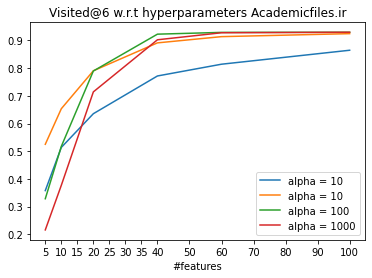

In [25]:
plt.plot(factors[:6], visited6s[:6], label='alpha = 10')
plt.plot(factors[6:12], visited6s[6:12], label='alpha = 10')
plt.plot(factors[12:18], visited6s[12:18], label='alpha = 100')
plt.plot(factors[18:24], visited6s[18:24], label='alpha = 1000')
plt.title("Visited@6 w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'visited@6_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)

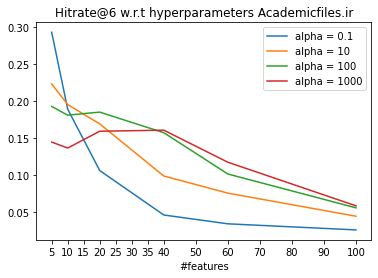

In [26]:
plt.plot(factors[:6], hitRate6s[:6], label='alpha = 0.1')
plt.plot(factors[6:12], hitRate6s[6:12], label='alpha = 10')
plt.plot(factors[12:18], hitRate6s[12:18], label='alpha = 100')
plt.plot(factors[18:24], hitRate6s[18:24], label='alpha = 1000')
plt.title("Hitrate@6 w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'hitrate@6_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)

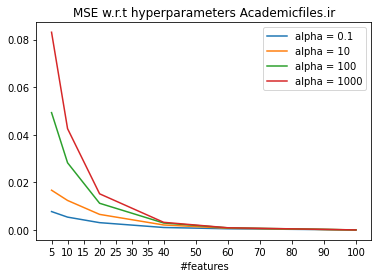

In [27]:
plt.plot(factors[:6], MSEs[:6], label='alpha = 0.1')
plt.plot(factors[6:12], MSEs[6:12], label='alpha = 10')
plt.plot(factors[12:18], MSEs[12:18], label='alpha = 100')
plt.plot(factors[18:24], MSEs[18:24], label='alpha = 1000')
plt.title("MSE w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'MSE_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)

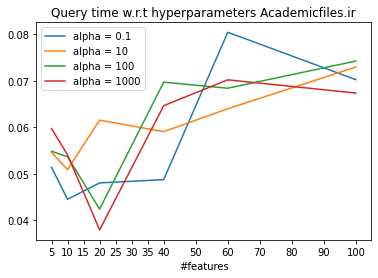

In [28]:
plt.plot(factors[:6], qTime[:6], label='alpha = 0.1')
plt.plot(factors[6:12], qTime[6:12], label='alpha = 10')
plt.plot(factors[12:18], qTime[12:18], label='alpha = 100')
plt.plot(factors[18:24], qTime[18:24], label='alpha = 1000')
plt.title("Query time w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'querytime_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)

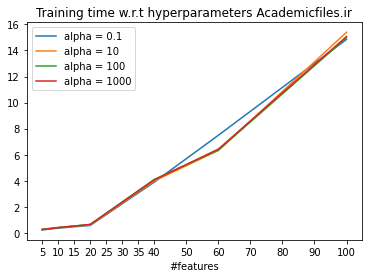

In [29]:
plt.plot(factors[:6], trainingTime[:6], label='alpha = 0.1')
plt.plot(factors[6:12], trainingTime[6:12], label='alpha = 10')
plt.plot(factors[12:18], trainingTime[12:18], label='alpha = 100')
plt.plot(factors[18:24], trainingTime[18:24], label='alpha = 1000')
plt.title("Training time w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'trainingtime_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)